In [62]:
import os
import numpy as np
import random
import glob
import nibabel as nib
import matplotlib.pyplot as plt
from tifffile import imsave
from tqdm import tqdm, trange

from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import Dataset

### NOTE
index 355 of training set (seg.nii) needs to be cleaned up to look like the rest of the folders/files

In [33]:
BASE_DIR_SEG = "../data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
scaler = MinMaxScaler()

## Inspect Dataset

In [34]:
print(os.listdir(BASE_DIR_SEG))
path = os.path.join(BASE_DIR_SEG, sorted(os.listdir(BASE_DIR_SEG))[354])
print(path)
print(os.listdir(path))

['BraTS20_Training_357', 'BraTS20_Training_210', 'BraTS20_Training_166', 'BraTS20_Training_331', 'BraTS20_Training_108', 'BraTS20_Training_264', 'BraTS20_Training_294', 'BraTS20_Training_364', 'BraTS20_Training_295', 'BraTS20_Training_307', 'BraTS20_Training_266', 'BraTS20_Training_137', 'BraTS20_Training_180', 'BraTS20_Training_291', 'BraTS20_Training_348', 'BraTS20_Training_142', 'BraTS20_Training_297', 'BraTS20_Training_243', 'BraTS20_Training_079', 'BraTS20_Training_152', 'BraTS20_Training_053', 'BraTS20_Training_136', 'BraTS20_Training_167', 'BraTS20_Training_225', 'BraTS20_Training_196', 'BraTS20_Training_238', 'BraTS20_Training_288', 'BraTS20_Training_293', 'BraTS20_Training_221', 'BraTS20_Training_211', 'BraTS20_Training_028', 'BraTS20_Training_338', 'BraTS20_Training_018', 'BraTS20_Training_232', 'BraTS20_Training_085', 'BraTS20_Training_220', 'BraTS20_Training_341', 'BraTS20_Training_306', 'BraTS20_Training_353', 'BraTS20_Training_268', 'BraTS20_Training_065', 'BraTS20_Traini

In [35]:
test_image_flair = nib.load(os.path.join(path, 'BraTS20_Training_355_flair.nii')).get_fdata()
print(test_image_flair.shape)
# flatten => reform the 3D volume =? scale [0.0, 1.0]
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.shape)

(240, 240, 155)
(240, 240, 155)


In [36]:
test_image_t1 = nib.load(os.path.join(path, 'BraTS20_Training_355_t1.nii')).get_fdata()
print(test_image_t1.shape)
# flatten => reform the 3D volume =? scale [0.0, 1.0]
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
print(test_image_t1.shape)

(240, 240, 155)
(240, 240, 155)


In [40]:
test_image_t1ce = nib.load(os.path.join(path, 'BraTS20_Training_355_t1ce.nii')).get_fdata()
print(test_image_t1ce.shape)
# flatten => reform the 3D volume =? scale [0.0, 1.0]
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)
print(test_image_t1ce.shape)

(240, 240, 155)
(240, 240, 155)


In [37]:
test_image_t2 = nib.load(os.path.join(path, 'BraTS20_Training_355_t2.nii')).get_fdata()
print(test_image_t2.shape)
# flatten => reform the 3D volume =? scale [0.0, 1.0]
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)
print(test_image_t2.shape)

(240, 240, 155)
(240, 240, 155)


In [38]:
test_mask = nib.load(os.path.join(path, 'BraTS20_Training_355_seg.nii')).get_fdata()
test_mask = test_mask.astype(np.uint8)
print(test_mask.shape)

print(np.unique(test_mask)) # 0, 1, 2, 4
test_mask[test_mask == 4] = 3 # 0, 1, 2, 3
print(np.unique(test_mask))

(240, 240, 155)
[0 1 2 4]
[0 1 2 3]


Text(0.5, 1.0, 'Image seg')

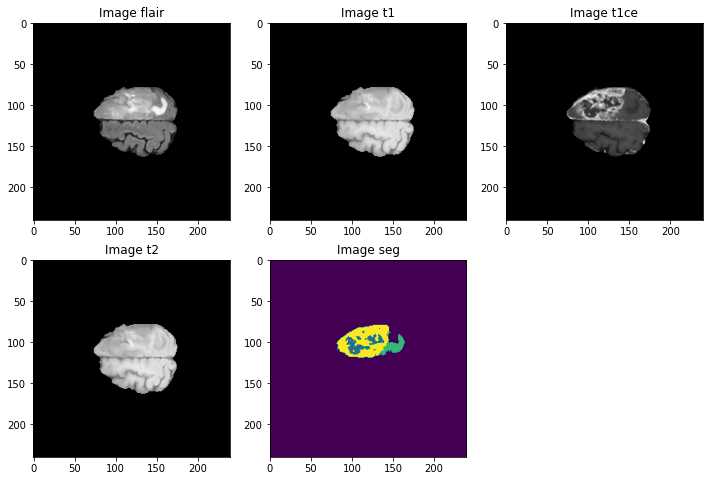

In [43]:
# NOTE: not all slices are useful/labelled
n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:, :, n_slice], cmap='gray')
plt.title('Image flair')

plt.subplot(232)
plt.imshow(test_image_t1[:, :, n_slice], cmap='gray')
plt.title('Image t1')

plt.subplot(233)
plt.imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
plt.title('Image t1ce')

plt.subplot(234)
plt.imshow(test_image_t2[:, :, n_slice], cmap='gray')
plt.title('Image t2')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Image seg')
plt.show()

In [45]:
# combine flair, t1ce and t2 (most information) into multichannel image
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

# crop to a size divisible by 64 so we can extract 64x64x64 patches
combined_x = combined_x[56:184, 56:184, 131:141]  # 128x128x128
test_mask = test_mask[56:184, 56:184, 131:141]

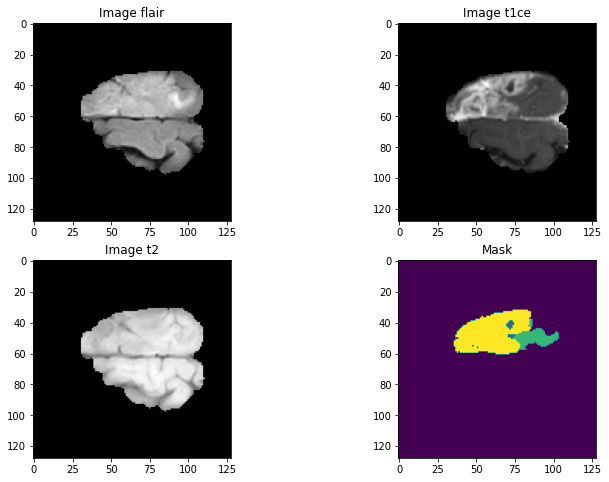

In [49]:
n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')

plt.subplot(223)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()

In [67]:
print(BASE_DIR_SEG)
print(path)
imsave(os.path.join(path, 'combined355.tif'), combined_x)
np.save(os.path.join(path, 'combined355.npy'), combined_x)

TiffWriter: data are stored as RGB with contiguous samples. Specify the 'photometric' parameter to silence this warning


../data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
../data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355


## Make dataset

In [70]:
BASE_DIR_SEG_TRAIN = "../data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
scaler = MinMaxScaler()

flair_list = sorted(glob.glob(BASE_DIR_SEG_TRAIN + "/*/*flair.nii"))
t1ce_list = sorted(glob.glob(BASE_DIR_SEG_TRAIN + "/*/*t1ce.nii"))
t2_list = sorted(glob.glob(BASE_DIR_SEG_TRAIN + "/*/*t2.nii"))
mask_list = sorted(glob.glob(BASE_DIR_SEG_TRAIN + "/*/*seg.nii"))

In [72]:
# 1-hot encodes a tensor
def to_categorical(y, num_classes):
  return np.eye(num_classes, dtype='uint8')[y]

In [76]:
os.makedirs(os.path.join(BASE_DIR_SEG_TRAIN, "input_data_3channels/images"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR_SEG_TRAIN, "input_data_3channels/masks"), exist_ok=True)

for i in (t := trange(len(t2_list))):
  t.set_description(f"[Train] Processing image and masks {i}")

  image_flair = nib.load(os.path.join(flair_list[i])).get_fdata()
  image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

  image_t1ce= nib.load(os.path.join(t1ce_list[i])).get_fdata()
  image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

  image_t2 = nib.load(os.path.join(t2_list[i])).get_fdata()
  image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

  mask = nib.load(os.path.join(mask_list[i])).get_fdata()
  mask = mask.astype(np.uint8)
  mask[mask == 4] = 3 # 0, 1, 2, 3

  combined_images = np.stack([image_flair, image_t1ce, image_t2], axis=3)
  combined_images = combined_images[56:184, 56:184, 131:141]  # 128x128x128
  mask = mask[56:184, 56:184, 131:141]

  val, counts = np.unique(mask, return_counts=True)

  # at least 1% useful volume with labels that are not
  if (1 - (counts[0]/counts.sum())) > 0.01:
    t.write(f"Saving {i} ...")
    mask = to_categorical(mask, num_classes=4)
    np.save(os.path.join(BASE_DIR_SEG_TRAIN, "input_data_3channels/images/image_" + str(i)+'.npy'), combined_images)
    np.save(os.path.join(BASE_DIR_SEG_TRAIN, "input_data_3channels/masks/mask_" + str(i)+'.npy'), mask)


[Train] Processing image and masks 32:   9%|█████                                                     | 32/369 [00:11<02:00,  2.80it/s]

Saving ...


[Train] Processing image and masks 34:   9%|█████▎                                                    | 34/369 [00:12<02:00,  2.79it/s]

Saving ...


[Train] Processing image and masks 62:  17%|█████████▋                                                | 62/369 [00:22<02:28,  2.07it/s]

Saving ...


[Train] Processing image and masks 98:  27%|███████████████▍                                          | 98/369 [00:41<02:27,  1.83it/s]

Saving ...


[Train] Processing image and masks 120:  33%|██████████████████▏                                     | 120/369 [00:52<02:09,  1.92it/s]

Saving ...


[Train] Processing image and masks 125:  34%|██████████████████▉                                     | 125/369 [00:55<02:07,  1.92it/s]

Saving ...


[Train] Processing image and masks 132:  36%|████████████████████                                    | 132/369 [00:59<02:07,  1.85it/s]

Saving ...


[Train] Processing image and masks 135:  37%|████████████████████▍                                   | 135/369 [01:00<02:04,  1.88it/s]

Saving ...


[Train] Processing image and masks 140:  38%|█████████████████████▏                                  | 140/369 [01:03<02:11,  1.74it/s]

Saving ...


[Train] Processing image and masks 157:  43%|███████████████████████▊                                | 157/369 [01:12<01:54,  1.86it/s]

Saving ...


[Train] Processing image and masks 176:  48%|██████████████████████████▋                             | 176/369 [01:22<01:39,  1.95it/s]

Saving ...


[Train] Processing image and masks 212:  57%|████████████████████████████████▏                       | 212/369 [01:40<01:19,  1.97it/s]

Saving ...


[Train] Processing image and masks 225:  61%|██████████████████████████████████▏                     | 225/369 [01:46<01:10,  2.03it/s]

Saving ...


[Train] Processing image and masks 263:  71%|███████████████████████████████████████▉                | 263/369 [02:06<00:55,  1.90it/s]

Saving ...


[Train] Processing image and masks 274:  74%|█████████████████████████████████████████▌              | 274/369 [02:12<00:48,  1.96it/s]

Saving ...


[Train] Processing image and masks 306:  83%|██████████████████████████████████████████████▍         | 306/369 [02:28<00:33,  1.90it/s]

Saving ...


[Train] Processing image and masks 313:  85%|███████████████████████████████████████████████▌        | 313/369 [02:32<00:30,  1.86it/s]

Saving ...


[Train] Processing image and masks 321:  87%|████████████████████████████████████████████████▋       | 321/369 [02:36<00:25,  1.91it/s]

Saving ...


[Train] Processing image and masks 347:  94%|████████████████████████████████████████████████████▋   | 347/369 [02:52<00:15,  1.44it/s]

Saving ...


[Train] Processing image and masks 355:  96%|█████████████████████████████████████████████████████▉  | 355/369 [02:57<00:09,  1.41it/s]

Saving ...


[Train] Processing image and masks 368: 100%|████████████████████████████████████████████████████████| 369/369 [03:07<00:00,  1.96it/s]

Saving ...


In [86]:
# INGORE ME
BASE_DIR_SEG_VAL = "../data/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

flair_list_val = sorted(glob.glob(BASE_DIR_SEG_VAL + "/*/*flair.nii"))
t1ce_list_val = sorted(glob.glob(BASE_DIR_SEG_VAL + "/*/*t1ce.nii"))
t2_list_val = sorted(glob.glob(BASE_DIR_SEG_VAL + "/*/*t2.nii"))
mask_list_val = sorted(glob.glob(BASE_DIR_SEG_VAL + "/*/*seg.nii"))

print(len(flair_list_val))
print(len(t1ce_list_val))
print(len(t2_list_val))
print(len(mask_list_val))

125
125
125
0


In [83]:
# INGORE ME
os.makedirs(os.path.join(BASE_DIR_SEG_VAL, "input_data_3channels/images"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR_SEG_VAL, "input_data_3channels/masks"), exist_ok=True)

for i in (t := trange(len(t2_list_val))):
  t.set_description(f"[Val] Processing image and masks {i}")

  image_flair = nib.load(os.path.join(flair_list_val[i])).get_fdata()
  image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

  image_t1ce= nib.load(os.path.join(t1ce_list_val[i])).get_fdata()
  image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

  image_t2 = nib.load(os.path.join(t2_list_val[i])).get_fdata()
  image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

  # mask = nib.load(os.path.join(mask_list_val[i])).get_fdata()
  # mask = mask.astype(np.uint8)
  # mask[mask == 4] = 3 # 0, 1, 2, 3

  combined_images = np.stack([image_flair, image_t1ce, image_t2], axis=3)
  combined_images = combined_images[56:184, 56:184, 131:141]  # 128x128x128
  # mask = mask[56:184, 56:184, 131:141]

  # val, counts = np.unique(mask, return_counts=True)

  # at least 1% useful volume with labels that are not
  # if (1 - (counts[0]/counts.sum())) > 0.01:
  #   t.write("Saving ...")
  #   mask = to_categorical(mask, num_classes=4)
  #   np.save(os.path.join(BASE_DIR_SEG_VAL, "input_data_3channels/images/image_" + str(i)+'.npy'), combined_images)
  #   np.save(os.path.join(BASE_DIR_SEG_VAL, "input_data_3channels/masks/mask_" + str(i)+'.npy'), mask)


[Val] Processing image and masks 0:   0%|                                                                      | 0/125 [00:00<?, ?it/s]


IndexError: list index out of range

In [90]:
import splitfolders

input_folder = BASE_DIR_SEG_TRAIN + "/input_data_3channels/"
output_folder = BASE_DIR_SEG_TRAIN + "/input_data_128/"
print(input_folder)
print(output_folder)

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)


Copying files: 26 files [00:00, 233.25 files/s]

../data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/input_data_3channels/
../data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/input_data_128/


Copying files: 42 files [00:00, 144.12 files/s]
